In [1]:
from functions import *

## Expectations

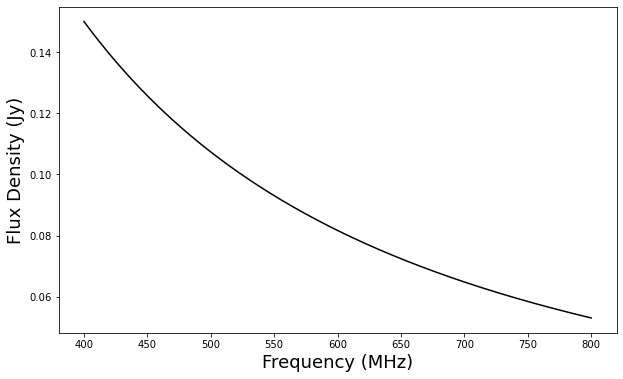

In [2]:
# Spectrum of the pulsar
freqs = np.linspace(800, 400, 1024)
pulsar_spectrum = flux_density(
    freqs, 
    ref_flux = 0.15,
    ref_freq = 400, 
    spectral_index = -1.5
)

fig = plt.figure(figsize=(10,6))
plt.plot(freqs, pulsar_spectrum, color='black')
plt.xlabel('Frequency (MHz)', fontsize=18)
plt.ylabel('Flux Density (Jy)', fontsize=18)
plt.show()

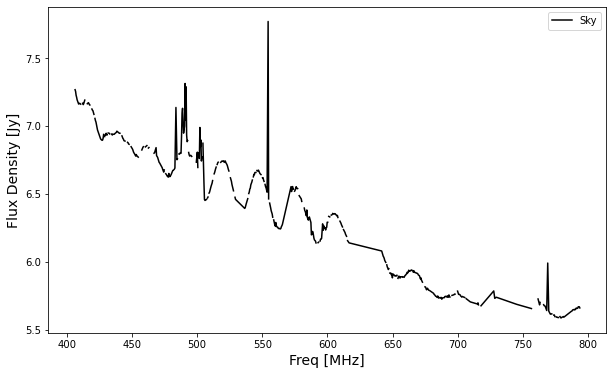

In [3]:
# Load average sky spectrum (SEFD)
sky_data = np.load("./data/calibrated_sky.npz")
sky_array = sky_data["array"]
sky_spectrum = sky_data["spectrum"]
sky_freq_mask = sky_data["freq_mask"]
df = sky_data["freq_bandwidth"]
dt = sky_data["sampling_time"]

fig = plt.figure(figsize=(10, 6))
plt.plot(
    freqs[sky_freq_mask], 
    sky_spectrum[sky_freq_mask],
    color='black',
    label='Sky'
)
plt.ylabel('Flux Density [Jy]', fontsize=14)
plt.xlabel('Freq [MHz]', fontsize=14)
plt.legend()
plt.show()

In [4]:
# Calibrator spectrum 
freqs = np.linspace(800, 400, 1024)
cal_spectrum = flux_density(freqs)

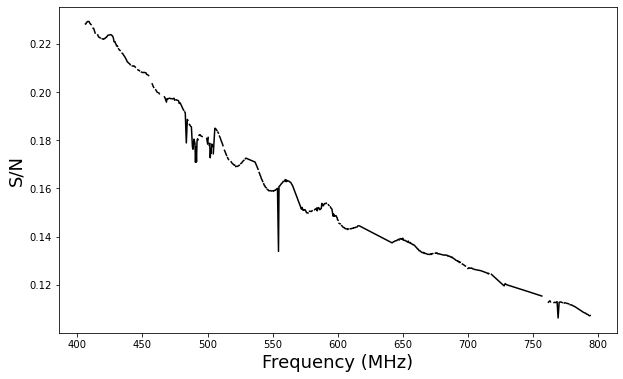

In [5]:
# Given that S/N is proportional to Sv/Ssys * sqrt(N)
N = 1
sn = pulsar_spectrum[sky_freq_mask]/ sky_spectrum[sky_freq_mask] * np.sqrt(dt* df* N)

fig = plt.figure(figsize=(10,6))
plt.plot(freqs[sky_freq_mask], sn, color='black')
plt.xlabel('Frequency (MHz)', fontsize=18)
plt.ylabel('S/N', fontsize=18)
plt.show()

In [6]:
sn_400_1 = sn[-1]
sn_desired = 2
N = np.power(sn_desired/ sn_400_1, 2)
print(f"Number of foldings required to achieve S/N 2: {N}")

Number of foldings required to achieve S/N 2: 77.98680664060242


## Load and Visulize Pulsar Data

Output()

Output()

Output()

Output()

Output()

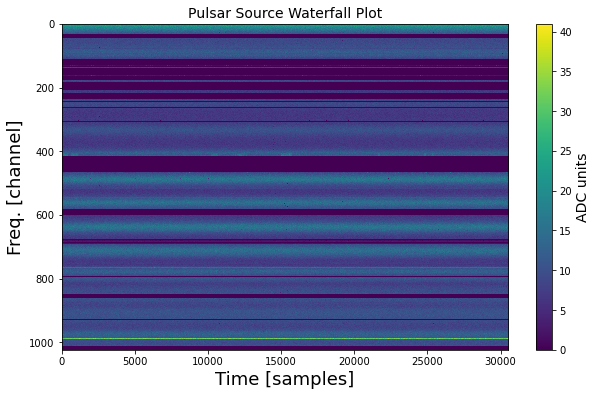

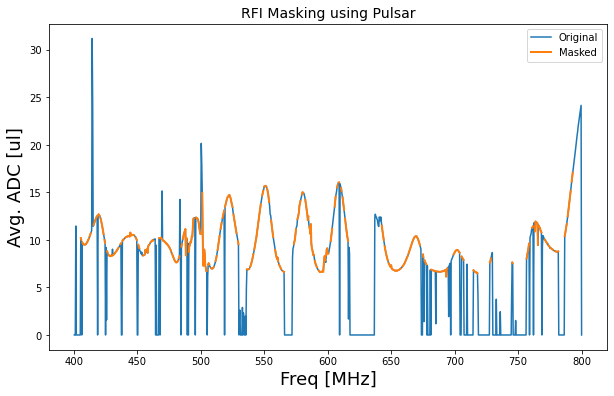

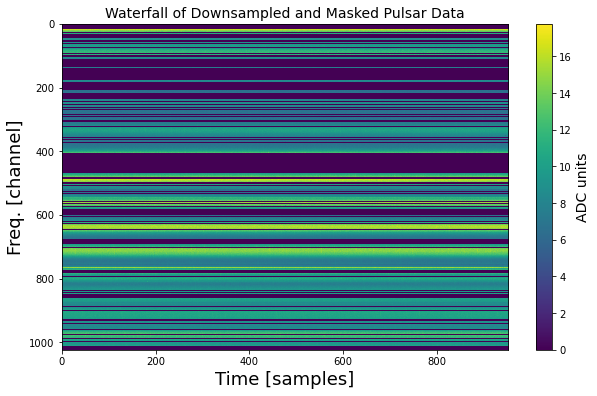

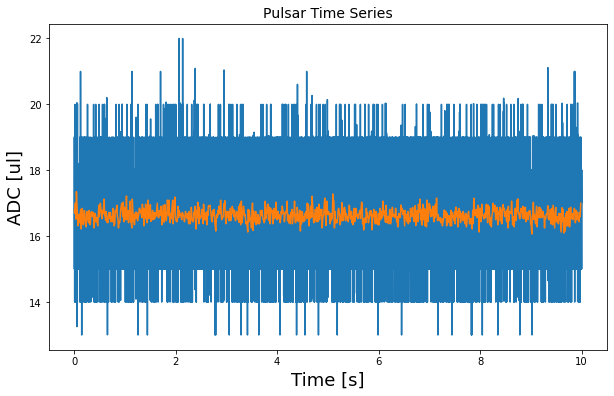

In [7]:
# Read in the data
pulsar = FilReader("./data/pulsardata.fil") 
Pretty(pulsar.header)

pulsar.compute_stats()
pulsar_data = pulsar.read_block(0, pulsar.header.nsamples, pulsar.header.fch1, pulsar.header.nchans)
pulsar_array = pulsar_data.data

# Mask the RFI
_, chan_mask = pulsar.clean_rfi(
    method = "mad",
    threshold=3, 
    outfile_name = "./data/pulsardata_masked.fil",
)
pulsar_masked = FilReader("./data/pulsardata_masked.fil") 
pulsar_masked.compute_stats()

freq_mask = pulsar_masked.chan_stats.mean == 0

# Downsample the data
pulsar_masked.downsample(
    tfactor = 32, 
    outfile_name = "./data/pulsardata_masked_f1_t32.fil"
)
pulsar_32 = FilReader("./data/pulsardata_masked_f1_t32.fil") 
pulsar_32.compute_stats()
pulsar_data_32 = pulsar_32.read_block(0, pulsar_32.header.nsamples, pulsar_32.header.fch1, pulsar_32.header.nchans)
pulsar_32_array = pulsar_data_32.data

# Plot the waterfall
fig = plt.figure(figsize=(10, 6))
im = plt.imshow(pulsar_array, aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label('ADC units', fontsize=14)
plt.title('Pulsar Source Waterfall Plot', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.show()

# Plot the mean spectrum
fig = plt.figure(figsize=(10, 6))
plt.plot(
    pulsar_masked.header.chan_freqs, 
    pulsar.chan_stats.mean, 
)
plt.plot(
    pulsar_masked.header.chan_freqs, 
    np.where(~freq_mask, pulsar_masked.chan_stats.mean, np.nan), 
    linewidth=2, 
)
plt.ylabel('Avg. ADC [ul]', fontsize=18)
plt.xlabel('Freq [MHz]', fontsize=18)
plt.title('RFI Masking using Pulsar', fontsize=14)
plt.legend(['Original', 'Masked'])
plt.show()

# Waterfall of downsampled data
fig = plt.figure(figsize=(10, 6))
im = plt.imshow(pulsar_32_array,aspect='auto',interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label('ADC units', fontsize=14)
plt.title('Waterfall of Downsampled and Masked Pulsar Data', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.show()

# Timeseries
fig = plt.figure(figsize=(10, 6))
plt.plot(
    np.arange(pulsar.header.nsamples) * pulsar.header.tsamp,
    pulsar_array[~freq_mask,:][1,:]
)
plt.plot(
    np.arange(pulsar_32.header.nsamples) * pulsar_32.header.tsamp,
    pulsar_32_array[~freq_mask,:][1,:]
)
plt.ylabel('ADC [ul]', fontsize=18)
plt.xlabel('Time [s]', fontsize=18)
plt.title('Pulsar Time Series', fontsize=14)
plt.show()

### Normalize pulsar data

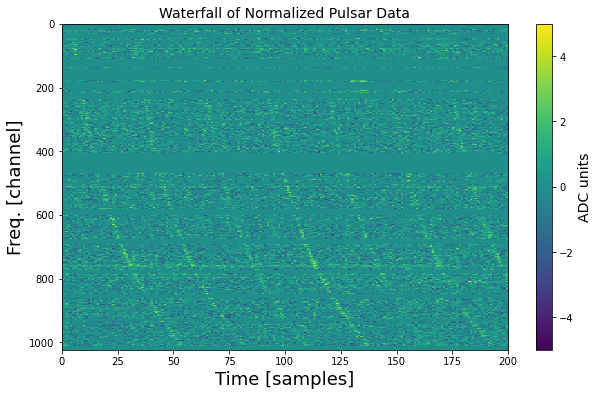

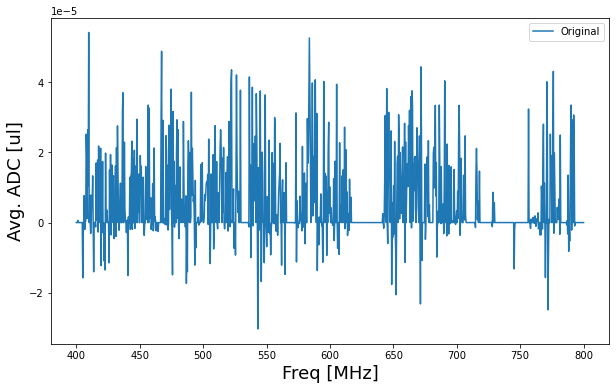

In [8]:
# Normalization
# psr_normalized = normalize_data_per_channel(
#     pulsar_32_array, 
#     freq_mask,    
#     invert_mask=True
# )
psr_normalized = pulsar_data_32.normalise()
psr_normalized_array = psr_normalized.data

fig = plt.figure(figsize=(10, 6))
im = plt.imshow(psr_normalized_array, aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label('ADC units', fontsize=14)
im.set_clim(-5, 5)
plt.title('Waterfall of Normalized Pulsar Data', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.xlim(0, 200) 
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(
    freqs, 
    np.mean(psr_normalized_array, axis=1)
)
plt.ylabel('Avg. ADC [ul]', fontsize=18)
plt.xlabel('Freq [MHz]', fontsize=18)
# plt.title('RFI Masking using Pulsar', fontsize=14)
plt.legend(['Original', 'Masked'])
plt.show()

## DM Search 

### Obtain the S/N as a function of DM and time

In [9]:
pulsar_data_32_dmt = psr_normalized.dmt_transform(50, dmsteps=1000)
pulsar_data_32_dmt.dms

array([  0.       ,   0.1001001,   0.2002002,   0.3003003,   0.4004004,
         0.5005005,   0.6006006,   0.7007007,   0.8008008,   0.9009009,
         1.001001 ,   1.1011012,   1.2012012,   1.3013014,   1.4014014,
         1.5015016,   1.6016016,   1.7017018,   1.8018018,   1.901902 ,
         2.002002 ,   2.102102 ,   2.2022023,   2.3023024,   2.4024024,
         2.5025024,   2.6026027,   2.7027028,   2.8028028,   2.9029028,
         3.0030031,   3.1031032,   3.2032032,   3.3033032,   3.4034035,
         3.5035036,   3.6036036,   3.7037036,   3.803804 ,   3.903904 ,
         4.004004 ,   4.104104 ,   4.204204 ,   4.304304 ,   4.4044046,
         4.5045047,   4.6046047,   4.7047048,   4.804805 ,   4.904905 ,
         5.005005 ,   5.105105 ,   5.2052054,   5.3053055,   5.4054055,
         5.5055056,   5.6056056,   5.7057056,   5.8058057,   5.9059057,
         6.0060062,   6.1061063,   6.2062063,   6.3063064,   6.4064064,
         6.5065064,   6.6066065,   6.7067065,   6.806807 ,   6.9

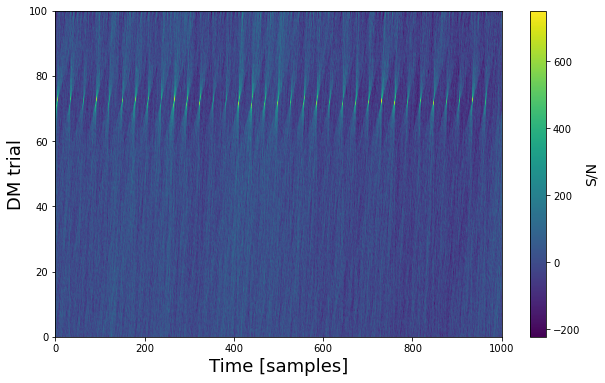

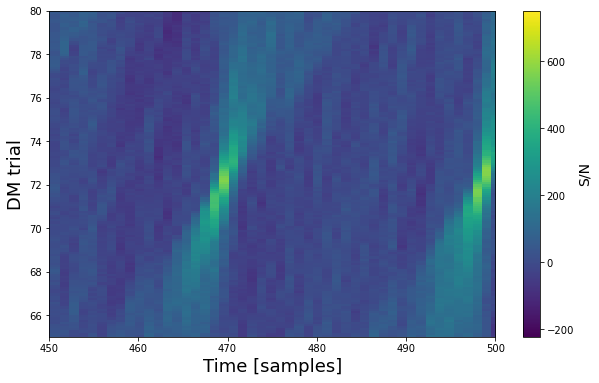

In [10]:
# print(pulsar_data_32_dmt.dms)
plt.figure(figsize=(10,6))
im = plt.imshow(
    pulsar_data_32_dmt.data, 
    aspect='auto', 
    interpolation='nearest', 
    extent=[
        0, 
        pulsar_data_32_dmt.data.shape[0], 
        pulsar_data_32_dmt.dms[0], 
        pulsar_data_32_dmt.dms[-1]
    ]
)
cbar = plt.colorbar(im)
cbar.set_label("S/N", fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('DM trial', fontsize=18)
# plt.xlim(300,500)
# plt.ylim(25, 5)
plt.show()

plt.figure(figsize=(10,6))
im = plt.imshow(
    pulsar_data_32_dmt.data,
    aspect='auto',
    interpolation='nearest',
    extent=[
        0, 
        pulsar_data_32_dmt.data.shape[0], 
        pulsar_data_32_dmt.dms[0], 
        pulsar_data_32_dmt.dms[-1]
    ]
)
cbar = plt.colorbar(im)
cbar.set_label("S/N", fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('DM trial', fontsize=18)
plt.xlim(450, 500)
plt.ylim(65, 80)
plt.show()

### FFT of S/N(DM,t)

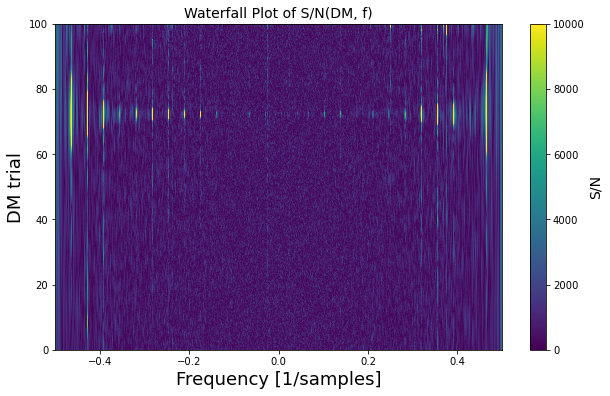

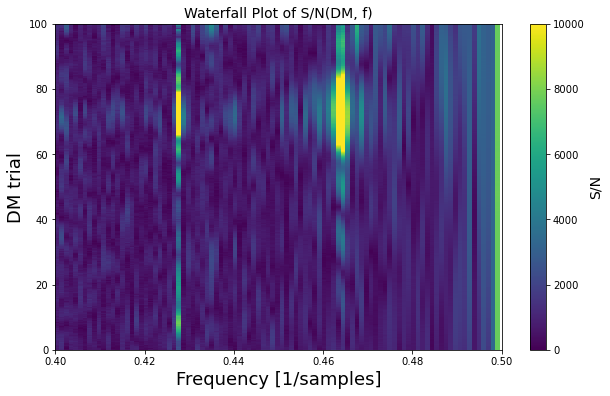

In [11]:
# sn_dm_f = np.fft.fftshift(
#     np.fft.fft(pulsar_data_32_dmt.data, axis=1),
#     axes=0
# )
sn_dm_f = np.fft.fft(pulsar_data_32_dmt.data, axis=1)
num_time_samples = pulsar_data_32_dmt.data.shape[1]
fft_freqs = np.fft.fftfreq(num_time_samples)

clip = 1e4

# Plot the waterfall of S/N(DM, f)
plt.figure(figsize=(10, 6))
im = plt.imshow(
    np.abs(sn_dm_f), 
    aspect='auto', 
    interpolation='nearest',
    extent=[
        fft_freqs.min(), 
        fft_freqs.max(), 
        pulsar_data_32_dmt.dms[0], 
        pulsar_data_32_dmt.dms[-1]
    ]
)
cbar = plt.colorbar(im)
cbar.set_label("S/N", fontsize=14)
im.set_clim(0, clip)
plt.xlabel('Frequency [1/samples]', fontsize=18)
plt.ylabel('DM trial', fontsize=18)
plt.title('Waterfall Plot of S/N(DM, f)', fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
im = plt.imshow(
    np.abs(sn_dm_f), 
    aspect='auto', 
    interpolation='nearest',
    extent=[
        fft_freqs.min(), 
        fft_freqs.max(), 
        pulsar_data_32_dmt.dms[0], 
        pulsar_data_32_dmt.dms[-1]
    ]
)
cbar = plt.colorbar(im)
cbar.set_label("S/N", fontsize=14)
im.set_clim(0, clip)
plt.xlim(0.4, 0.5)
plt.xlabel('Frequency [1/samples]', fontsize=18)
plt.ylabel('DM trial', fontsize=18)
plt.title('Waterfall Plot of S/N(DM, f)', fontsize=14)
plt.show()


### S/N maximizing DM and period

In [12]:
# Find the max S/N
max_idx = np.unravel_index(np.argmax(np.abs(sn_dm_f)), sn_dm_f.shape)
max_dm_index, max_freq_index = max_idx

# Extract the corresponding DM and frequency
max_dm = pulsar_data_32_dmt.dms[max_dm_index]
max_freq = fft_freqs[max_freq_index]

# Convert frequency to period
max_period = 1 / max_freq if max_freq != 0 else np.inf
max_period = max_period * pulsar_data_32_dmt.header.tsamp

# Display results
print(
    f"Max S/N found at: DM = {max_dm}\n",
    f"Frequency = {max_freq}\n", 
    f"Period = {max_period}\n", 
    f"Sampling time = {pulsar_data_32_dmt.header.tsamp}"
)

Max S/N found at: DM = 27.82782745361328
 Frequency = 0.07240293809024134
 Period = 0.1448250620289855
 Sampling time = 0.01048576


### Dedisperse

Output()

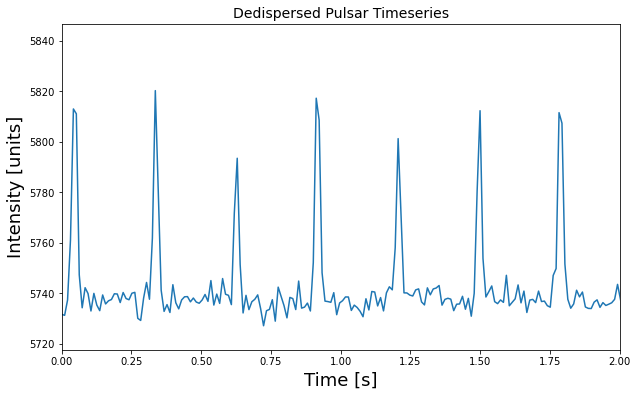

In [36]:
# Not used in the analysis
pulsar_32_dedisperse = pulsar_32.dedisperse(max_dm)
time_bins = np.arange(pulsar_32_dedisperse.data.size) * pulsar_data_32_dmt.header.tsamp

# Plot the dedispersed timeseries
plt.figure(figsize=(10, 6))
plt.plot(time_bins, pulsar_32_dedisperse.data)
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Intensity [units]', fontsize=18)
plt.title('Dedispersed Pulsar Timeseries', fontsize=14)
plt.xlim(0, 2)
plt.show()

## Folding 

2025-02-27 22:56:13 WARNING  - sigpyproc.base - Number of phase bins is greater than period/sampling time

Output()

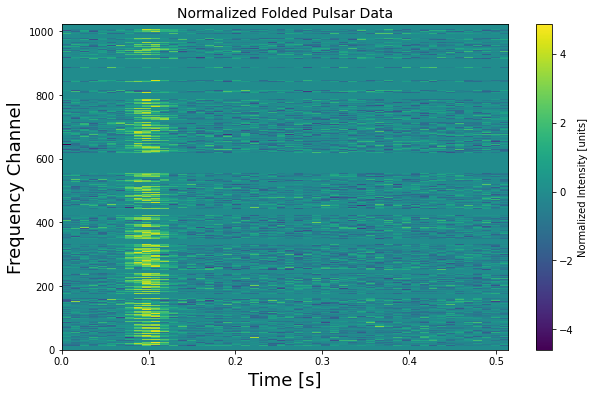

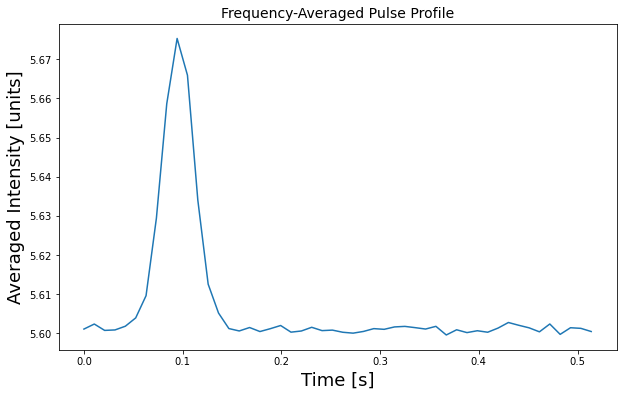

In [49]:
# Fold the pulsar data using the S/N maximizing parameters
pulsar_32_folded = pulsar_32.fold(
    period = max_period*2, 
    dm = max_dm,
    nints = 1,  
    nbands = 1024,  
    # nbins = int(0.5 // pulsar_data_32.header.tsamp)  
)

# Normalize the folded data
pulsar_32_folded_normalized = normalize_data_per_channel(
    pulsar_32_folded.data[0, :, :], 
    freq_mask, 
    invert_mask=True
)
time_bins = np.arange(pulsar_32_folded_normalized.shape[1]) * pulsar_32.header.tsamp

# Plot the normalized folded data
plt.figure(figsize=(10,6))
plt.imshow(
    pulsar_32_folded_normalized, 
    aspect='auto', 
    interpolation='nearest', 
    extent=[
        time_bins[0], 
        time_bins[-1],
        0, 
        pulsar_32_folded_normalized.shape[0], 
    ]
)
plt.colorbar(label='Normalized Intensity [units]')
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Frequency Channel', fontsize=18)
plt.title('Normalized Folded Pulsar Data', fontsize=14)
plt.show()

# Average over frequency channels to obtain the frequency-averaged pulse profile
pulse_profile = np.mean(pulsar_32_folded.data[0, :, :], axis=0)

# Plot the frequency-averaged pulse profile
time_bins = np.arange(pulse_profile.size) * pulsar_32.header.tsamp
plt.figure(figsize=(10,6))
plt.plot(time_bins, pulse_profile)
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Averaged Intensity [units]', fontsize=18)
plt.title('Frequency-Averaged Pulse Profile', fontsize=14)
plt.show()